In [3]:
# notebook settings
%load_ext autoreload
%autoreload 2

# external imports
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from IPython.display import Image

# internal imports
from pympc.geometry.polyhedron import Polyhedron
from pympc.dynamics.discrete_time_systems import LinearSystem, AffineSystem, PieceWiseAffineSystem
from pympc.control.hybrid_benchmark.controllers import HybridModelPredictiveController

# Problem set-up

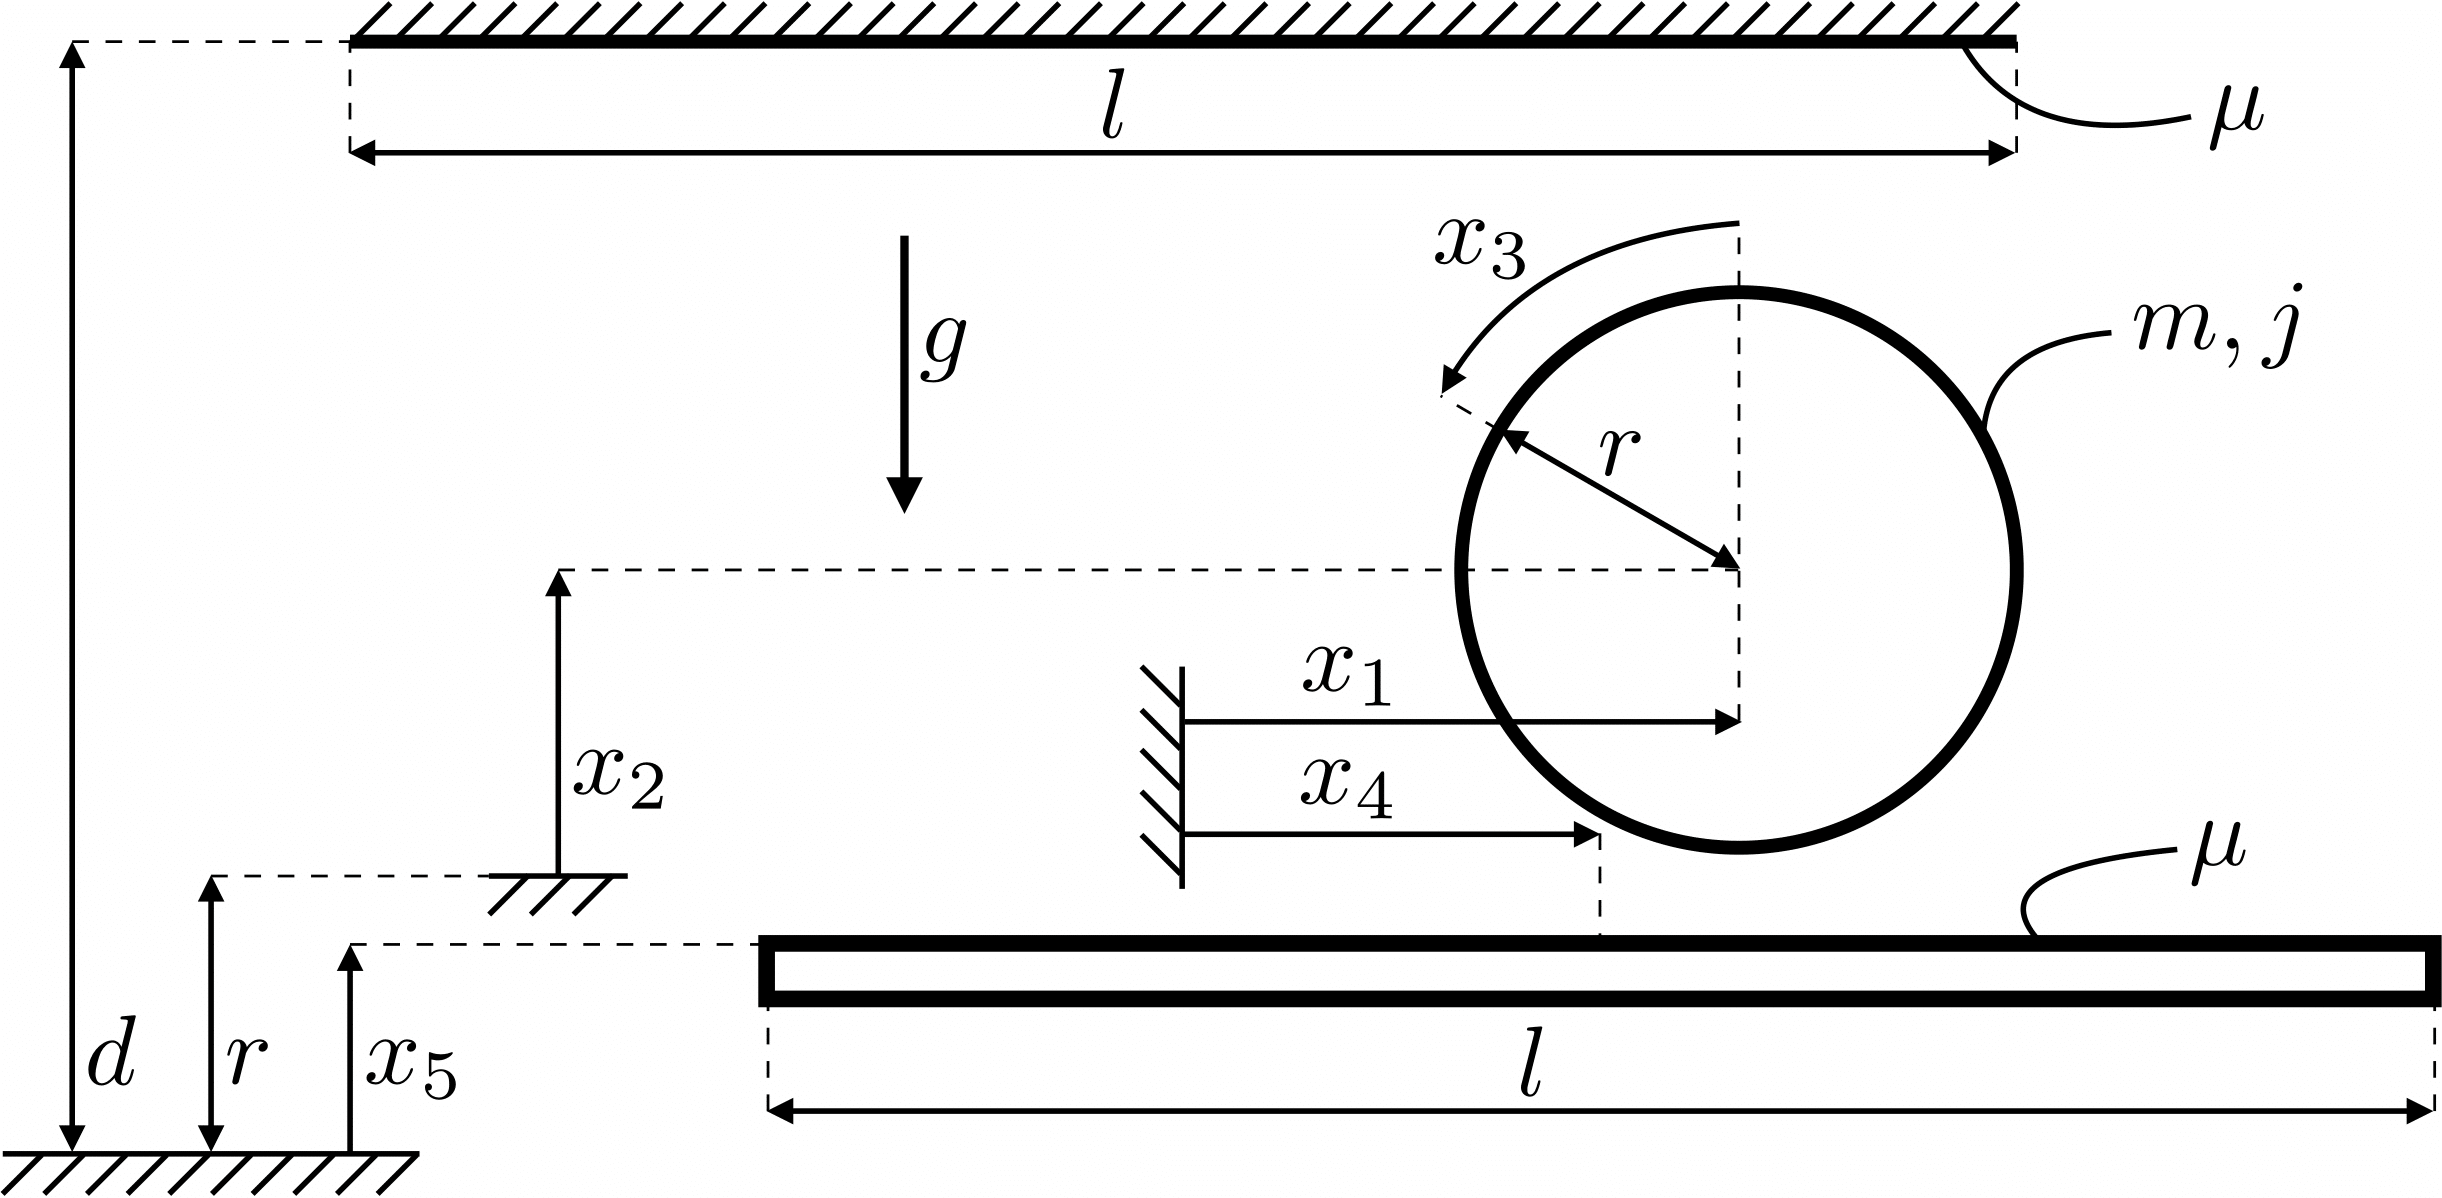

In [2]:
# schematic representation of the system
Image("ball_and_paddle.png")

In [6]:
# numeric parameters of the system
m = 1.
r = .1
j = .4*m*r**2.
d = .4
l = .3
mu = .2
g = 10.
h = .05

In [7]:


# symbolic state
xb, yb, tb = sp.symbols('xb yb tb') # position of the ball
xf, yf = sp.symbols('xf yf') # position of the floor
xdb, ydb, tdb = sp.symbols('xdb ydb tdb') # velocity of the ball
xdf, ydf = sp.symbols('xdf ydf') # velocity of the floor
x = sp.Matrix([
    xb, yb, tb,
    xf, yf,
    xdb, ydb, tdb,
    xdf, ydf
])

# symbolic input
xd2f, yd2f = sp.symbols('xd2f yd2f') # acceleration of the floor
u = sp.Matrix([
    xd2f, yd2f
])

# contact forces
ftf, fnf = sp.symbols('ftf fnf') # floor force
ftc, fnc = sp.symbols('ftc fnc') # ceiling force

In [8]:
# ball velocity update
xdb_next = xdb + h*ftf/m - h*ftc/m
ydb_next = ydb + h*fnf/m - h*fnc/m - h*g
tdb_next = tdb + r*h*ftf/j + r*h*ftc/j

# ball position update
xb_next = xb + h*xdb_next
yb_next = yb + h*ydb_next
tb_next = tb + h*tdb_next

# floor velocity update
xdf_next = xdf + h*xd2f
ydf_next = ydf + h*yd2f

# floor position update
xf_next = xf + h*xdf_next
yf_next = yf + h*ydf_next

# state update
x_next = sp.Matrix([
    xb_next, yb_next, tb_next,
    xf_next, yf_next,
    xdb_next, ydb_next, tdb_next,
    xdf_next, ydf_next
])

In [9]:
# relative tangential velocity
sliding_velocity_floor = xdb_next + r*tdb_next - xdf_next
sliding_velocity_ceiling = xdb_next - r*tdb_next

# gap function floor
gap_floor = yb_next - yf_next

# gap function ceiling
gap_ceiling = d - 2.*r - yb_next

# ball distance to boundaries
ball_on_floor = sp.Matrix([
    xb_next - xf_next - l,
    xf_next - xb_next - l
])
ball_on_ceiling = sp.Matrix([
    xb_next - l,
    - xb_next - l
])

In [10]:
# state bounds
x_max = np.array([
    l, d-2.*r, 1.2*np.pi, # ball config
    l, d-2.*r-.05, # floor config
    2., 2., 10., # ball vel
    2., 2. # floor vel
])
x_min = - x_max

# input bounds
u_max = np.array([
    30., 30., # floor acc
])
u_min = - u_max

# domain bounds
xu = x.col_join(u)
xu_min = np.concatenate((x_min, u_min))
xu_max = np.concatenate((x_max, u_max))

In [11]:
# discrete time dynamics in mode 1
# (ball in the air)

# set forces to zero
f_m1 = {ftf: 0., fnf: 0., ftc: 0., fnc: 0.}

# get dynamics
x_next_m1 = x_next.subs(f_m1)
S1 = AffineSystem.from_symbolic(x, u, x_next_m1)

# build domain
D1 = Polyhedron.from_bounds(xu_min, xu_max)

# - gap <= 0 with floor and ceiling
gap_floor_m1 = gap_floor.subs(f_m1)
gap_ceiling_m1 = gap_ceiling.subs(f_m1)
D1.add_symbolic_inequality(xu, sp.Matrix([- gap_floor_m1]))
D1.add_symbolic_inequality(xu, sp.Matrix([- gap_ceiling_m1]))

# check domain
assert D1.bounded
assert not D1.empty

In [12]:
# discrete time dynamics in mode 2
# (ball sticking with the floor, not in contact with the ceiling)

# enforce sticking
fc_m2 = {ftc: 0., fnc: 0.}
ftf_m2 = sp.solve(sp.Eq(sliding_velocity_floor.subs(fc_m2), 0), ftf)[0]
fnf_m2 = sp.solve(sp.Eq(gap_floor.subs(fc_m2), 0), fnf)[0]
f_m2 = fc_m2.copy()
f_m2.update({ftf: ftf_m2, fnf: fnf_m2})

# get dynamics
x_next_m2 = x_next.subs(f_m2)
S2 = AffineSystem.from_symbolic(x, u, x_next_m2)

# build domain
D2 = Polyhedron.from_bounds(xu_min, xu_max)

# gap <= 0 with floor
D2.add_symbolic_inequality(xu, sp.Matrix([gap_floor_m1]))

# - gap <= 0 with ceiling
D2.add_symbolic_inequality(xu, sp.Matrix([- gap_ceiling_m1]))

# ball not falling down the floor
D2.add_symbolic_inequality(xu, ball_on_floor.subs(f_m2))

# friction cone
D2.add_symbolic_inequality(xu, sp.Matrix([ftf_m2 - mu*fnf_m2]))
D2.add_symbolic_inequality(xu, sp.Matrix([- ftf_m2 - mu*fnf_m2]))

# check domain
assert D2.bounded
assert not D2.empty

In [13]:
# discrete time dynamics in mode 3
# (ball sliding right on the floor, not in contact with the ceiling)

# enforce sticking
f_m3 = {ftf: -mu*fnf_m2, fnf: fnf_m2, ftc: 0., fnc: 0.}

# get dynamics
x_next_m3 = x_next.subs(f_m3)
S3 = AffineSystem.from_symbolic(x, u, x_next_m3)

# build domain
D3 = Polyhedron.from_bounds(xu_min, xu_max)

# gap <= 0 with floor
D3.add_symbolic_inequality(xu, sp.Matrix([gap_floor_m1]))

# - gap <= 0 with ceiling
D3.add_symbolic_inequality(xu, sp.Matrix([- gap_ceiling_m1]))

# ball not falling down the floor
D3.add_symbolic_inequality(xu, ball_on_floor.subs(f_m3))

# positive relative velocity
D3.add_symbolic_inequality(xu, sp.Matrix([- sliding_velocity_floor.subs(f_m3)]))

# check domain
assert D3.bounded
assert not D3.empty

In [14]:
# discrete time dynamics in mode 4
# (ball sliding left on the floor, not in contact with the ceiling)

# enforce sticking
f_m4 = {ftf: mu*fnf_m2, fnf: fnf_m2, ftc: 0., fnc: 0.}

# get dynamics
x_next_m4 = x_next.subs(f_m4)
S4 = AffineSystem.from_symbolic(x, u, x_next_m4)

# build domain
D4 = Polyhedron.from_bounds(xu_min, xu_max)

# gap <= 0 with floor
D4.add_symbolic_inequality(xu, sp.Matrix([gap_floor_m1]))

# - gap <= 0 with ceiling
D4.add_symbolic_inequality(xu, sp.Matrix([- gap_ceiling_m1]))

# ball not falling down the floor
D4.add_symbolic_inequality(xu, ball_on_floor.subs(f_m4))

# negative relative velocity
D4.add_symbolic_inequality(xu, sp.Matrix([sliding_velocity_floor.subs(f_m4)]))

# check domain
assert D4.bounded
assert not D4.empty

In [15]:
# discrete time dynamics in mode 5
# (ball sticking on the ceiling, not in contact with the floor)

# enforce sticking
ff_m5 = {ftf: 0., fnf: 0.}
ftc_m5 = sp.solve(sp.Eq(sliding_velocity_ceiling.subs(ff_m5), 0), ftc)[0]
fnc_m5 = sp.solve(sp.Eq(gap_ceiling.subs(ff_m5), 0), fnc)[0]
f_m5 = ff_m5.copy()
f_m5.update({ftc: ftc_m5, fnc: fnc_m5})

# get dynamics
x_next_m5 = x_next.subs(f_m5)
S5 = AffineSystem.from_symbolic(x, u, x_next_m5)

# build domain
D5 = Polyhedron.from_bounds(xu_min, xu_max)

# - gap <= 0 with floor
D5.add_symbolic_inequality(xu, sp.Matrix([- gap_floor_m1]))

# gap <= 0 with ceiling
D5.add_symbolic_inequality(xu, sp.Matrix([gap_ceiling_m1]))

# ball in contact with the ceiling
D5.add_symbolic_inequality(xu, ball_on_ceiling.subs(f_m5))

# friction cone
D5.add_symbolic_inequality(xu, sp.Matrix([ftc_m5 - mu*fnc_m5]))
D5.add_symbolic_inequality(xu, sp.Matrix([- ftc_m5 - mu*fnc_m5]))

# check domain
assert D5.bounded
assert not D5.empty

In [16]:
# discrete time dynamics in mode 6
# (ball sliding right on the ceiling, not in contact with the floor)

# enforce sticking
f_m6 = {ftc: -mu*fnc_m5, fnc: fnc_m5, ftf: 0., fnf: 0.}

# get dynamics
x_next_m6 = x_next.subs(f_m6)
S6 = AffineSystem.from_symbolic(x, u, x_next_m6)

# build domain
D6 = Polyhedron.from_bounds(xu_min, xu_max)

# - gap <= 0 with floor
D6.add_symbolic_inequality(xu, sp.Matrix([- gap_floor_m1]))

# gap <= 0 with ceiling
D6.add_symbolic_inequality(xu, sp.Matrix([gap_ceiling_m1]))

# ball in contact with the ceiling
D6.add_symbolic_inequality(xu, ball_on_ceiling.subs(f_m6))

# positive relative velocity
D6.add_symbolic_inequality(xu, sp.Matrix([- sliding_velocity_ceiling.subs(f_m6)]))

# check domain
assert D6.bounded
assert not D6.empty

In [17]:
# discrete time dynamics in mode 7
# (ball sliding left on the ceiling, not in contact with the floor)

# enforce sticking
f_m7 = {ftc: mu*fnc_m5, fnc: fnc_m5, ftf: 0., fnf: 0.}

# get dynamics
x_next_m7 = x_next.subs(f_m7)
S7 = AffineSystem.from_symbolic(x, u, x_next_m7)

# build domain
D7 = Polyhedron.from_bounds(xu_min, xu_max)

# - gap <= 0 with floor
D7.add_symbolic_inequality(xu, sp.Matrix([- gap_floor_m1]))

# gap <= 0 with ceiling
D7.add_symbolic_inequality(xu, sp.Matrix([gap_ceiling_m1]))

# ball in contact with the ceiling
D7.add_symbolic_inequality(xu, ball_on_ceiling.subs(f_m7))

# negative relative velocity
D7.add_symbolic_inequality(xu, sp.Matrix([sliding_velocity_ceiling.subs(f_m7)]))

# check domain
assert D7.bounded
assert not D7.empty

In [18]:
# list of dynamics
S_list = [S1, S2, S3, S4, S5, S6, S7]

# list of domains
D_list = [D1, D2, D3, D4, D5, D6, D7]

# PWA system
S = PieceWiseAffineSystem(S_list, D_list)

In [19]:
# controller parameters
N = 20
Q = np.diag([
    1., 1., .01,
    1., 1.,
    1., 1., .01,
    1., 1.
])*2. # times 2 to cancel out the 1/2 
R = np.diag([
    .01, .001
])*2. # times 2 to cancel out the 1/2 
P = np.zeros((S.nx, S.nx))

# terminal set and cost
X_N = Polyhedron.from_bounds(*[np.zeros(S.nx)]*2)

# mixed-integer formulations and norms of the objective
methods = ['PF', 'CH', 'BM', 'MLD']
norms = ['inf', 'one', 'two']

In [20]:
# initial condition
x0 = np.array([
    0., 0., np.pi,
    0., 0.,
    0., 0., 0.,
    0., 0.
])

# Home-made branch and bound

In [18]:
controller = HybridModelPredictiveController(S, N, Q, R, P, X_N, 'PF', 'two')

Academic license - for non-commercial use only - expires 2021-03-20
Using license file C:\Users\User\gurobi.lic
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


In [19]:
from pympc.control.hybrid_benchmark.branch_and_bound import branch_and_bound, best_first
def solver(identifier, objective_cutoff):
    return controller.solve_relaxation(x0, identifier, objective_cutoff)

ModuleNotFoundError: No module named 'pygraphviz'

In [23]:
solves = np.load('data_hscc/flip_benchmark.npy',allow_pickle=True,encoding='latin1').item()
print(solves['two']['CH']['cost'])
sol = branch_and_bound(solver, best_first, controller.explore_in_reverse_chronological_order)

37.20776102044876


NameError: name 'branch_and_bound' is not defined

# Comparison of the different mixed-integer formulations

In [21]:

controller = HybridModelPredictiveController(S, N, Q, R, P, X_N, method='CH', norm='one')
u_mip, x_mip, ms_mip, cost_mip = controller.feedforward(x0)

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Discarded solution information
Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 4945 rows, 2795 columns and 16375 nonzeros
Model fingerprint: 0x520137d7
Variable types: 2690 continuous, 105 integer (105 binary)
Coefficient statistics:
  Matrix range     [5e-04, 1e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [3e+00, 3e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 1852 rows and 1312 columns
Presolve time: 0.11s
Presolved: 3093 rows, 1483 columns, 11199 nonzeros
Variable types: 1390 continuous, 93 integer (93 binary)

Root relaxation: objective 4.218612e+00, 2431 iterations, 0.08 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   

In [28]:
# solves of the MICP with all the methods and the norms (takes hours!)
solves = {}

#methods = ['PF', 'CH']
#norms = ['inf', 'one']
# for all the norms of the objective
for norm in norms:
    print('\nnorm:', norm)
    solves[norm] = {}
    
    # for all the mixed-integer formulations
    for method in methods:
        print('  \nmethod:', method)
        
        # build the copntroller
        controller = HybridModelPredictiveController(S, N, Q, R, P, X_N, method, norm)
        
        # cut solution if longer than 1 h
        controller.prog.setParam('TimeLimit', 3600)
        
        # solve and store result
        u_mip, x_mip, ms_mip, cost_mip = controller.feedforward(x0)
        solves[norm][method] = {
            'time': controller.prog.Runtime,
            'nodes': controller.prog.NodeCount,
            'mip_gap': controller.prog.MIPGap,
            'u': u_mip,
            'x': x_mip,
            'ms': ms_mip,
            'cost': cost_mip
        }
        
# save result
# np.save('data_hscc/flip_benchmark', solves)


norm: inf
  
method: PF
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Changed value of parameter TimeLimit to 3600.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Discarded solution information
Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 9540 rows, 3757 columns and 27660 nonzeros
Model fingerprint: 0x80ecbd44
Variable types: 3617 continuous, 140 integer (140 binary)
Coefficient statistics:
  Matrix range     [5e-04, 1e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [3e+00, 3e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 2893 rows and 1819 columns
Presolve time: 0.11s
Presolved: 6647 rows, 1938 columns, 21233 nonzeros
Variable types: 1807 continuous, 131 integer (131 binary)

Root relaxation: objective 4.287076e+00, 9341 iterations, 0.84 seconds

    Nodes 

  8905  2382   18.76323   23   30   29.06250   17.21558  40.8%   818  558s
  9129  2386   22.88755   23   31   29.06250   17.28031  40.5%   812  567s
  9307  2404   22.88353   34   30   29.06250   17.35977  40.3%   810  577s
  9516  2441   18.27478   24   37   29.06250   17.44044  40.0%   806  585s
  9683  2486   19.66500   29   30   29.06250   17.47518  39.9%   805  595s
  9897  2514     cutoff   27        29.06250   17.55403  39.6%   800  604s
 10125  2527   19.62579   23   36   29.06250   17.67860  39.2%   795  614s
 10324  2565   19.15919   22   43   29.06250   17.73217  39.0%   793  623s
 10522  2588   21.67179   24   38   29.06250   17.82237  38.7%   790  632s
 10736  2619 infeasible   37        29.06250   17.91285  38.4%   788  643s
 10976  2599   19.16456   33   39   29.06250   18.00400  38.1%   783  652s
 11172  2597   18.47545   23   33   29.06250   18.17213  37.5%   782  661s
H11180  2597                      29.0625020   18.17213  37.5%   782  661s
 11296  2630   28.12743  

 44196  2280   28.21999   37   21   28.48452   28.04724  1.54%   422 1396s
 44626  2337     cutoff   43        28.48452   28.04724  1.54%   419 1400s
 45192  2365   28.37766   45   19   28.48452   28.04936  1.53%   416 1405s
 45423  2322     cutoff   33        28.48452   28.05998  1.49%   414 1410s
 46635  2370   28.20843   45   21   28.48452   28.07954  1.42%   406 1416s
 47112  2377     cutoff   42        28.48452   28.07994  1.42%   403 1420s
 47805  2386   28.30231   38   20   28.48452   28.08307  1.41%   399 1425s
 48531  2318     cutoff   38        28.48452   28.09821  1.36%   395 1430s
 49223  2189   28.48238   40   16   28.48452   28.12066  1.28%   391 1435s
 50153  1993   28.23428   37   22   28.48452   28.17524  1.09%   385 1440s
 51243  1839   28.28193   42   26   28.48452   28.23183  0.89%   378 1446s
 51985  1830   28.35226   46   20   28.48452   28.25539  0.80%   374 1450s
 52815  1865   28.32458   53   18   28.48452   28.27327  0.74%   370 1456s
 53049  1965   28.36803  

  7624  2028   23.79488   41   17   28.48452   17.29824  39.3%   281  128s
  7943  2156 infeasible   32        28.48452   17.33208  39.2%   280  133s
  8201  2304   17.55086   27   25   28.48452   17.33285  39.1%   281  137s
  8573  2355 infeasible   37        28.48452   17.33285  39.1%   278  141s
  8821  2413 infeasible   38        28.48452   17.33496  39.1%   279  146s
H 8899  2413                      28.4845199   17.33618  39.1%   278  146s
  9162  2488 infeasible   41        28.48452   17.35472  39.1%   277  151s
  9564  2572     cutoff   33        28.48452   17.37285  39.0%   276  157s
  9983  2617   24.43474   39   15   28.48452   17.38058  39.0%   275  163s
 10449  2749   17.71192   30   20   28.48452   17.40444  38.9%   273  169s
 11068  2791   21.50978   28   27   28.48452   17.48760  38.6%   269  173s
 11468  2827   20.22168   33   25   28.48452   17.52384  38.5%   267  178s
 11899  2837   28.46531   33   16   28.48452   17.55086  38.4%   264  182s
 12275  2816   28.16282  

  4756  1634   47.42601   21   35   64.06768   18.96126  70.4%   374  132s
  4914  1661   33.45444   31   27   64.06768   19.11354  70.2%   378  136s
H 5059  1659                      63.9382740   19.46314  69.6%   378  136s
  5067  1703   57.10291   37   19   63.93827   19.52240  69.5%   378  141s
  5276  1707     cutoff   36        63.93827   19.73494  69.1%   378  145s
  5441  1709 infeasible   21        63.93827   20.28870  68.3%   383  150s
  5600  1717   59.68221   33   29   63.93827   21.39824  66.5%   388  155s
  5787  1747 infeasible   36        63.93827   22.10365  65.4%   388  161s
  6009  1833   39.05055   33   30   63.93827   24.00685  62.5%   389  165s
  6226  1882   43.66549   20   27   63.93827   24.41355  61.8%   388  171s
  6413  1956   48.63309   32   34   63.93827   24.65584  61.4%   386  176s
  6663  2019   33.36859   28   21   63.93827   25.12858  60.7%   385  181s
  6930  2085     cutoff   37        63.93827   25.38604  60.3%   383  186s
  7145  2184   44.03674  

 43522  5880   49.73133   42   13   63.93827   48.14759  24.7%   288  686s
 44492  5979   52.26179   37   26   63.93827   48.58252  24.0%   286  693s
 44895  5986   51.82639   43   34   63.93827   48.69817  23.8%   285  696s
 45333  5986   55.64770   43   24   63.93827   48.86875  23.6%   284  700s
 46382  6015     cutoff   36        63.93827   49.62434  22.4%   282  708s
 46814  6038   56.88081   50   14   63.93827   49.87974  22.0%   281  711s
 47743  6008     cutoff   37        63.93827   50.24360  21.4%   278  716s
 48617  5932     cutoff   41        63.93827   50.70275  20.7%   276  722s
 49031  5924 infeasible   36        63.93827   51.19903  19.9%   275  725s
 49759  5835   54.00525   42   25   63.93827   51.66580  19.2%   273  732s
 50194  5813   53.38637   42   26   63.93827   51.94275  18.8%   273  735s
 51036  5665   61.62959   51   22   63.93827   52.69923  17.6%   271  741s
 51979  5547     cutoff   43        63.93827   53.40600  16.5%   269  747s
 52838  5450   57.52321  

     0     0    3.64219    0   48          -    3.64219      -     -    0s
     0     0    3.64219    0   49          -    3.64219      -     -    0s
     0     0    3.66083    0   46          -    3.66083      -     -    0s
     0     0    3.66083    0   47          -    3.66083      -     -    0s
     0     0    3.66083    0   50          -    3.66083      -     -    0s
     0     0    3.66083    0   40          -    3.66083      -     -    1s
     0     0    3.66083    0   40          -    3.66083      -     -    1s
     0     0    3.66083    0   40          -    3.66083      -     -    1s
     0     0    3.66083    0   42          -    3.66083      -     -    1s
     0     0    3.66083    0   41          -    3.66083      -     -    1s
     0     0    3.66083    0   39          -    3.66083      -     -    1s
     0     2    3.66083    0   37          -    3.66083      -     -    2s
   247   169   29.68528   16   33          -    4.58500      -   209    5s
   750   437   34.81265  

 54592  5703   61.82318   36   27   63.93827   49.40704  22.7%   187  461s
 55106  5606   58.71388   48   22   63.93827   49.66831  22.3%   187  465s
 56295  5407     cutoff   40        63.93827   50.46918  21.1%   185  473s
 56881  5281   60.36700   35   25   63.93827   50.89753  20.4%   185  476s
 58099  4990   54.05979   39   12   63.93827   51.75619  19.1%   183  482s
 58639  4813   61.92735   42   23   63.93827   52.21977  18.3%   183  486s
 59677  4636 infeasible   48        63.93827   53.69530  16.0%   181  497s
 59689  4583   54.41069   31   31   63.93827   53.69530  16.0%   181  501s
 60744  4512 infeasible   36        63.93827   54.74413  14.4%   180  507s
 61340  4558     cutoff   43        63.93827   55.23752  13.6%   179  511s
 61863  4723     cutoff   40        63.93827   55.79528  12.7%   179  516s
 62621  4733   63.69001   56    6   63.93827   55.93763  12.5%   178  520s
 63483  4846   61.56989   60   21   63.93827   56.52413  11.6%   176  526s
 64302  4973     cutoff  

In [29]:
# loads the results above and prints the results
#solves = np.load('data_hscc/flip_benchmark.npy',allow_pickle=True,encoding='latin1').item()
for norm in norms:
    print('\nnorm:', norm)
    for method in methods:
        print('\n  method:', method)
        print('    mip gap:', solves[norm][method]['mip_gap'])
        print('    time:', solves[norm][method]['time'])
        print('    nodes:', solves[norm][method]['nodes'])


norm: inf

  method: PF
    mip gap: 0.0
    time: 1601.2169647216797
    nodes: 75427.0

  method: CH
    mip gap: 4.477077498456567e-09
    time: 359.7264862060547
    nodes: 51048.0

norm: one

  method: PF
    mip gap: 0.0
    time: 1119.3833141326904
    nodes: 154809.0

  method: CH
    mip gap: 0.0
    time: 745.509199142456
    nodes: 122847.0


# Animation

Animate the result with MeshCat (available at https://github.com/rdeits/meshcat-python)

In [ ]:
import meshcat
import meshcat.transformations as tf
from meshcat.geometry import Box, Sphere, Cylinder, MeshLambertMaterial
from meshcat.animation import Animation

In [ ]:
# load solution
solves = np.load('data_hscc/flip_benchmark.npy').item()

In [ ]:
# initialize visualizer
vis = meshcat.Visualizer()
vis.open()

In [ ]:
# geometric parameters of the ball and the paddle
tickness = .01
depth = .3

# colors of the scene
red = 0xff2222
blue = 0x2222ff
green = 0x22ff22
grey = 0x999999

# objects to animate
vis['ball'].set_object(
    Sphere(r),
    MeshLambertMaterial(color=blue)
)
vis['ball_stripe'].set_object(
    Cylinder(r/10., r*1.002), # a little larger than the ball to see it clearly
    MeshLambertMaterial(color=green)
)
vis['floor'].set_object(
    Box([depth, l*2., tickness]),
    MeshLambertMaterial(color=red)
)
vis['ceiling'].set_object(
    Box([depth, l*2., tickness]),
    MeshLambertMaterial(color=grey)
)

In [ ]:
# initialize animation
anim = Animation()

# animate e.g. the solution with infinity norm and convex-hull method
for t, xt in enumerate(solves['inf']['CH']['x']):
    with anim.at_frame(vis, t*h*30) as frame: # 30 frames per second to get real time
        frame['ball'].set_transform(
            tf.translation_matrix([0, xt[0], xt[1]+r])
        )
        frame['ball_stripe'].set_transform(
            tf.translation_matrix([0, xt[0], xt[1]+r]).dot(
                tf.rotation_matrix(xt[2], [1.,0.,0.])
            )
        )
        frame['floor'].set_transform(
            tf.translation_matrix([0, xt[3], xt[4]-tickness/2.])
        )
        frame['ceiling'].set_transform(
            tf.translation_matrix([0, 0, d+tickness/2.])
        )

# visualize result
vis.set_animation(anim)

# Plot optimal mode sequence

In [58]:
# load results
solves = np.load('data_hscc/flip_benchmark.npy',allow_pickle=True,encoding='latin1').item()

# optimal mode sequence e.g. in the infinity norm case
ms = solves['one']['PF']['ms']

# double the initial mode for plot purpose
ms = [ms[0]] + ms

# names of the modes
ms_legend = [
    '',
    'Slide left on paddle',
    'Stick/roll on paddle',
    'Slide right on paddle',
    'No contact',
    'Slide left on ceiling',
    'Stick/roll on ceiling',
    'Slide right on ceiling'
]

# reorder the mode sequence in such a way that they math with the order of the names
ms_map = {0: 3, 1: 1, 2: 2, 3: 0, 4: 5, 5: 6, 6: 4}
ms_reordered = [ms_map[m] for m in ms]

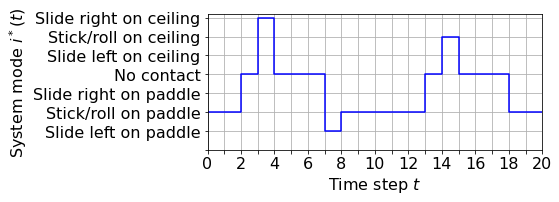

In [59]:
# change default size of matplotlib
plt.rc('font', size=16)

# initialize figure
plt.figure(figsize=(6,2.5))

# plot mode sequence
plt.step(range(N+1), ms_reordered, color='b')

# axis limits
plt.xlim(0, N)
plt.ylim(-.2, S.nm-.8)

# axis ticks
plt.xticks(range(N+1))
plt.gca().axes.xaxis.set_ticklabels([i if i%2==0 else '' for i in range(N+1)])
plt.yticks(range(-1,S.nm))
plt.gca().set_yticklabels(ms_legend)

# axis labels
plt.xlabel(r'Time step $t$')
plt.ylabel(r'System mode $i^*(t)$')

# misc
plt.grid(True)
# plt.savefig('optimal_mode_sequence.pdf',bbox_inches='tight')

# Compare formulations for different levels of relaxation

In [ ]:
# load solution
solves = np.load('data_hscc/flip_benchmark.npy').item()

In [34]:
# cost of each relaxation as a function of time (takes approx. 2 minutes)
costs = {}

# for all the norms of the objective
for norm in norms:
    print('\nnorm:', norm)
    costs[norm] = {}
    
    # for all the mixed-integer formulations
    for method in methods:
        print('  \nmethod:', method)
        costs[norm][method] = []
        
        # build controller
        controller = HybridModelPredictiveController(S, N, Q, R, P, X_N, method, norm)
        
        # fix the mode of the system to its optimal value for the initial t steps
        for ms in [solves[norm]['CH']['ms'][:t] for t in range(N+1)]:
            
            # solve the relaxation and normalize on the optimal value of the MICP
            cost = controller.solve_relaxation(x0, ms)[1]
            if cost is not None:
                cost /= solves[norm]['CH']['cost']
            costs[norm][method].append(cost)


norm: inf
  
method: PF
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Discarded solution information
  
method: CH
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Discarded solution information

norm: one
  
method: PF
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Discarded solution information
  
method: CH
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Discarded solution information


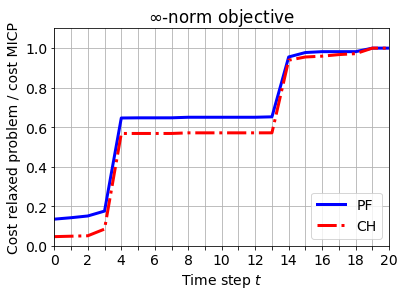

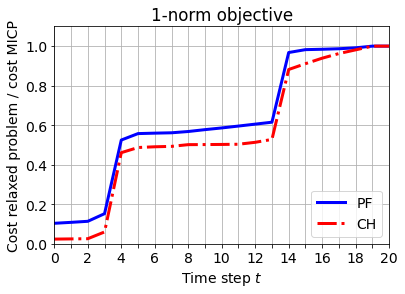

In [35]:
# change default colors and size of matplotlib
import matplotlib as mpl
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')
plt.rc('font', size=14)

# for all the norms of the objective
for norm in norms:
    
    # set line colors and styles
    colors = ['b', 'r', 'c','g']
    linestyles = ['-', '-.', '--', ':']
    
     # for all the mixed-integer formulations plot the relaxation ratio as a funtion of the time step
    for i, method in enumerate(methods):
        plt.plot(
            range(N+1),
            costs[norm][method],
            label=method,
            color=colors[i],
            linestyle=linestyles[i],
            linewidth=3
        )
        
    # axis limits
    plt.xlim((0, N))
    plt.ylim((0, 1.1))
    
    # plot titles
    if norm == 'inf':
        plt.title(r'$\infty$-norm objective')
    elif norm == 'one':
        plt.title(r'1-norm objective')
    elif norm == 'two':
        plt.title(r'Quadratic objective')
        
    # ticks
    plt.xticks(range(N+1)) # a tick per time step
    plt.gca().axes.xaxis.set_ticklabels([i if i%2==0 else '' for i in range(N+1)]) # label only even ticks
    
    # axis labels
    plt.xlabel(r'Time step $t$')
    plt.ylabel(r'Cost relaxed problem / cost MICP')

    # misc
    plt.legend(loc=4)
    plt.grid(True)
    # plt.savefig('relaxation_ratio_' + norm + '.pdf', bbox_inches='tight')
    plt.show()

# Objective as a function of the initial state ($x_1$ and $x_3$ only)

In [61]:
# solve relaxations for all MI formulations (takes tens of minutes)

# n_samples by n_samples grid in x1 and x3
n_samples = 51
xb_samples = np.linspace(0., x_max[0], n_samples)
tb_samples = np.linspace(-np.pi, np.pi, n_samples)

# cost of the relaxation for each point
cost = {'xb_samples': xb_samples, 'tb_samples':tb_samples}

# for all the norms of the objective
for norm in norms:
    print('\nnorm:', norm)
    cost[norm] = {}
    
    # for all the mixed-integer formulations
    for method in methods:
        print('  \nmethod:', method)
        
        # build controller
        controller = HybridModelPredictiveController(S, N, Q, R, P, X_N, method, norm)
        
        # cost matrix
        cost_mat = np.empty([n_samples]*2)
        
        # solve one convex program per point in the grid
        for i, xb in enumerate(xb_samples):
            for j, tb in enumerate(tb_samples):
                print(str(i) + ',' + str(j) + '   \r'),
                
                # initial state
                x0 = np.array([xb,0.,tb] + [0.]*7)
                
                # cost of the relaxation
                cost_mat[i,j] = controller.solve_relaxation(x0, {})[1]
                
        # fill matrix
        cost[norm][method] = cost_mat

# save data
# np.save('data_hscc/cost_relaxation_different_intial_conditions', cost)


norm: inf
  
method: PF
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
0,0   
Discarded solution information
0,1   
0,2   
0,3   
0,4   
0,5   
0,6   
0,7   
0,8   
0,9   
0,10   
0,11   
0,12   
0,13   
0,14   
0,15   
0,16   
0,17   
0,18   
0,19   
0,20   
0,21   
0,22   
0,23   
0,24   
0,25   
0,26   
0,27   
0,28   
0,29   
0,30   
0,31   
0,32   
0,33   
0,34   
0,35   
0,36   
0,37   
0,38   
0,39   
0,40   
0,41   
0,42   
0,43   
0,44   
0,45   
0,46   
0,47   
0,48   
0,49   
0,50   
1,0   
1,1   
1,2   
1,3   
1,4   
1,5   
1,6   
1,7   
1,8   
1,9   
1,10   
1,11   
1,12   
1,13   
1,14   
1,15   
1,16   
1,17   
1,18   
1,19   
1,20   
1,21   
1,22   
1,23   
1,24   
1,25   
1,26   
1,27   
1,28   
1,29   
1,30   
1,31   
1,32   
1,33   
1,34   
1,35   
1,36   
1,37   
1,38   
1,39   
1,40   
1,41   
1,42   
1,43   
1,44   
1,45   
1,46   
1,47   
1,48   
1,49   
1,50   
2,0   
2,1   
2,2   
2,3   
2,4   
2,5   
2,6   
2,7   
2,8   
2,9   


KeyboardInterrupt: 


norm: inf, method: PF


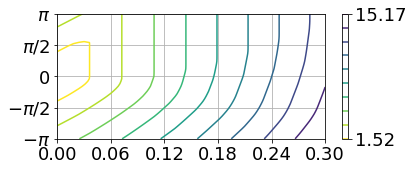


norm: inf, method: CH


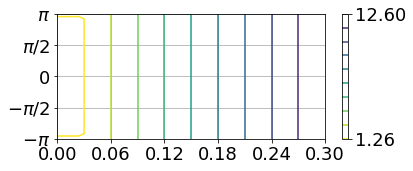


norm: one, method: PF


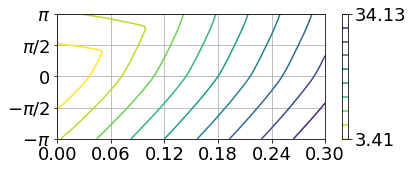


norm: one, method: CH


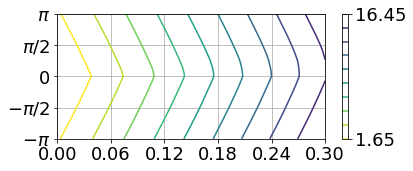

In [64]:
# plot cost of the relaxation as a function of x1 and x3

# change default size of matplotlib
plt.rc('font', size=18)

# load cost matrices
cost = np.load('data_hscc/cost_relaxation_different_intial_conditions.npy',allow_pickle=True,encoding='latin1').item()

# create grid x1 and x3
xb_samples = cost['xb_samples']
tb_samples = cost['tb_samples']
Xb, Tb = np.meshgrid(xb_samples, tb_samples)

# number of level curves in each plot
n_levels = 10

# for all the norms of the objective
for norm in norms:
    
    # for all the mixed-integer formulations
    for method in methods:
        print('\nnorm: %s, method: %s' % (norm, method))
        
        # initialize figure
        plt.figure(figsize=(6., 2.3))
        
        # cost matrix
        cm = cost[norm][method]

        # set desired levels and draw the contour plot
        levels = [(i+1)*np.nanmax(cm)/n_levels for i in range(n_levels)]
        cp = plt.contour(Xb, Tb, cm.T, levels=levels, cmap='viridis_r')
        
        # get colorbar
        cb = plt.colorbar(cp)
        
        # ticks of the colorbar (only first and last) limited to 2 decimals
        cb.set_ticks([cb.locator()[0],cb.locator()[-1]])
        cb.set_ticklabels(['%.2f'%cb.locator()[0],'%.2f'%cb.locator()[-1]])
        
        # axis ticks
        plt.xticks(np.linspace(0., x_max[0], 6))
        plt.yticks(np.linspace(-np.pi, np.pi, 5))
        plt.gca().axes.yaxis.set_ticklabels([r'$-\pi$',r'$-\pi/2$',0,r'$\pi/2$',r'$\pi$'])
        
        # misc
        plt.grid(True)
        # plt.savefig('cost_' + method + '_' + norm + '.pdf',bbox_inches='tight')
        plt.show()

In [ ]:
# samples of the MICP optimal value (takes days!)

# n_samples by n_samples grid in x1 and x3
n_samples = 11
xb_samples = np.linspace(0., x_max[0], n_samples)
tb_samples = np.linspace(-np.pi, np.pi, n_samples)

# cost of the MICP for each point
cost = {'xb_samples': xb_samples, 'tb_samples':tb_samples}

# for all the norms of the objective
for norm in norms:
    print('\nnorm:', norm)
    
    # build controller
    controller = HybridModelPredictiveController(S, N, Q, R, P, X_N, 'CH', norm)
    
    # cut after 5 h
    controller.prog.setParam('TimeLimit', 18000)
    
    # cost matrix
    cost_mat = np.empty([n_samples]*2)
        
    # solve one MICP program per point in the grid
    for i, xb in enumerate(xb_samples):
        for j, tb in enumerate(tb_samples):
            print(str(i) + ',' + str(j) + '   \r'),

            # initial state
            x0 = np.array([xb,0.,tb] + [0.]*7)
            
            # cost of the MICP
            cost_mat[i,j] = controller.feedforward(x0)[3]
            
    # fill matrix
    cost[norm] = cost_mat

# save data
# np.save('data_hscc/cost_micp_different_intial_conditions', cost)


norm: inf
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Changed value of parameter TimeLimit to 18000.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
0,0   
Discarded solution information
Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 6540 rows, 3511 columns and 21780 nonzeros
Model fingerprint: 0xc8c7874f
Variable types: 3371 continuous, 140 integer (140 binary)
Coefficient statistics:
  Matrix range     [5e-04, 1e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [3e+00, 3e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 2228 rows and 1623 columns
Presolve time: 0.14s
Presolved: 4312 rows, 1888 columns, 16209 nonzeros
Variable types: 1760 continuous, 128 integer (128 binary)

Root relaxation: objective 1.886774e+00, 3534 iterations, 0.13 seconds

    Nodes    |  

KeyboardInterrupt: 

Exception ignored in: 'gurobipy.logcallbackstub'
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\envs\newEnv\lib\site-packages\ipykernel\iostream.py", line 386, in write
    def write(self, string):
KeyboardInterrupt: 


   813   481    4.37005   21   41   31.53226    4.37005  86.1%   236   25s
H  845   469                      31.4412498    4.37005  86.1%   241   25s
H  916   486                      31.4339622    4.37005  86.1%   246   27s
H  924   463                      31.4338488    4.37005  86.1%   246   27s
H  953   457                      31.4193304    4.37005  86.1%   254   29s
H  957   437                      31.2701600    4.37005  86.0%   254   29s
   986   456    4.37005   38   39   31.27016    4.37005  86.0%   253   30s


KeyboardInterrupt: 

Exception ignored in: 'gurobipy.logcallbackstub'
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\envs\newEnv\lib\site-packages\ipykernel\iostream.py", line 386, in write
    def write(self, string):
KeyboardInterrupt: 


  1253   508 infeasible   44        31.24646    4.37005  86.0%   256   35s
H 1392   506                      31.1109632    4.37005  86.0%   253   37s
H 1393   490                      30.9620377    4.37005  85.9%   253   37s
H 1399   484                      30.9372403    4.37005  85.9%   253   37s
  1478   475   17.08606   48   26   30.93724    4.37005  85.9%   258   40s
  1822   559   16.12712   40   34   30.93724    4.37005  85.9%   265   45s
  2104   677   16.15307   33   42   30.93724    4.37005  85.9%   280   51s
  2365   778   16.11543   36   34   30.93724    4.37005  85.9%   283   55s
H 2481   786                      30.9314894    4.37005  85.9%   283   56s
H 2502   780                      29.8387009    4.37005  85.4%   286   57s
  2569   802   18.29657   38   44   29.83870    4.37005  85.4%   290   60s
  2893   906   22.21342   38   26   29.83870    4.37005  85.4%   297   65s
  3146   956 infeasible   42        29.83870    4.74409  84.1%   303   70s
H 3148   956             

KeyboardInterrupt: 

Exception ignored in: 'gurobipy.logcallbackstub'
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\envs\newEnv\lib\site-packages\ipykernel\iostream.py", line 386, in write
    def write(self, string):
KeyboardInterrupt: 


 40751  2061   28.42489   36   22   28.48452   27.17678  4.59%   215  487s
 41518  2225   27.77805   33   27   28.48452   27.20609  4.49%   212  492s
 42970  2230   28.43087   51   10   28.48452   27.32621  4.07%   208  496s


KeyboardInterrupt: 

Exception ignored in: 'gurobipy.logcallbackstub'
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\envs\newEnv\lib\site-packages\ipykernel\iostream.py", line 386, in write
    def write(self, string):
KeyboardInterrupt: 


 45156  1885   27.96906   48   15   28.48452   27.67176  2.85%   201  506s
 46460  1964     cutoff   51        28.48452   27.73823  2.62%   198  511s
 47547  1965   28.47666   47   12   28.48452   27.76105  2.54%   195  515s
 48826  1985   28.14517   47   15   28.48452   27.79410  2.42%   191  522s
 49930  1850   28.47321   58   12   28.48452   27.84393  2.25%   188  526s
 51341  1686     cutoff   55        28.48452   27.93234  1.94%   185  530s
 52851  1549     cutoff   48        28.48452   28.04724  1.54%   181  535s
 54125  1360     cutoff   42        28.48452   28.08208  1.41%   178  540s
 56261   991     cutoff   43        28.48452   28.22433  0.91%   173  546s
 57533   930     cutoff   47        28.48452   28.28519  0.70%   171  550s
 59018   840     cutoff   43        28.48452   28.31663  0.59%   168  555s
 61185   609     cutoff   56        28.48452   28.38292  0.36%   163  560s
 63295     0     cutoff   51        28.48452   28.43750  0.17%   159  566s

Cutting planes:
  Gomory

KeyboardInterrupt: 

Exception ignored in: 'gurobipy.logcallbackstub'
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\envs\newEnv\lib\site-packages\ipykernel\iostream.py", line 386, in write
    def write(self, string):
KeyboardInterrupt: 


  1740   739 infeasible   43        28.15949   16.05239  43.0%   235   50s
H 1836   683                      28.1578879   16.05239  43.0%   238   53s


KeyboardInterrupt: 

Exception ignored in: 'gurobipy.logcallbackstub'
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\envs\newEnv\lib\site-packages\ipykernel\iostream.py", line 386, in write
    def write(self, string):
KeyboardInterrupt: 


KeyboardInterrupt: 

Exception ignored in: 'gurobipy.logcallbackstub'
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\envs\newEnv\lib\site-packages\ipykernel\iostream.py", line 386, in write
    def write(self, string):
KeyboardInterrupt: 


KeyboardInterrupt: 

Exception ignored in: 'gurobipy.logcallbackstub'
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\envs\newEnv\lib\site-packages\ipykernel\iostream.py", line 386, in write
    def write(self, string):
KeyboardInterrupt: 


KeyboardInterrupt: 

Exception ignored in: 'gurobipy.logcallbackstub'
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\envs\newEnv\lib\site-packages\ipykernel\iostream.py", line 386, in write
    def write(self, string):
KeyboardInterrupt: 



norm: inf


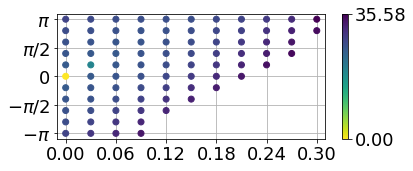


norm: one


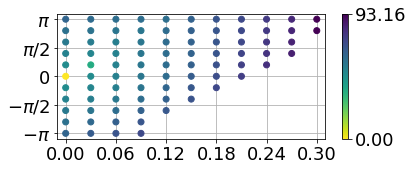


norm: two


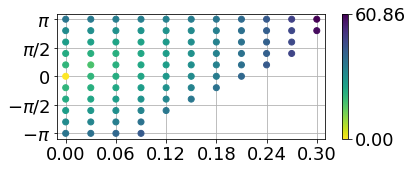

In [21]:
# plot cost of the MICP as a function of x1 and x3

# change default size of matplotlib
plt.rc('font', size=18)

# load cost matrices
cost = np.load('data_hscc/cost_micp_different_intial_conditions.npy',allow_pickle=True,encoding='latin1').item()

# create grid x1 and x3
xb_samples = np.concatenate([[i]*len(cost['tb_samples']) for i in cost['xb_samples']])
tb_samples = cost['tb_samples'].tolist()*len(cost['xb_samples'])

# number of level curves in each plot
n_levels = 10

# for all the norms of the objective
for norm in norms:
    print('\nnorm:', norm)
    
    # initialize figure
    plt.figure(figsize=(6., 2.3))
    
    # scatter the samples of the optimal value function
    c = cost[norm].flatten()
    sc = plt.scatter(
        xb_samples,
        tb_samples,
        c=c,
        cmap=plt.cm.get_cmap('viridis_r')
    )
    
    # get colorbar
    cb = plt.colorbar(sc)
    
    # colorbar ticks
    cb.set_ticks([min(c), max(c)])
    cb.set_ticklabels(['%.2f'%min(c),'%.2f'%max(c)])
    
    # axis limits
    plt.xlim(-.01,.31)
    plt.ylim(-np.pi-.3,np.pi+.3)
    
    # axis ticks
    plt.xticks(np.linspace(0., x_max[0], 6))
    plt.yticks(np.linspace(-np.pi, np.pi, 5))
    plt.gca().axes.yaxis.set_ticklabels([r'$-\pi$',r'$-\pi/2$',0,r'$\pi/2$',r'$\pi$'])
    
    # misc
    plt.grid(True)
    plt.gca().set_axisbelow(True)
    # plt.savefig('cost_mip_' + norm + '.pdf',bbox_inches='tight')
    plt.show()